# Set cover problem



## Data

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate

UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

## Reproductible intialization

In [43]:
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

iterations = 3_000

### Helper Functions

In [44]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Improved RHMC



In [45]:
def one_lambda_es(solution : np.ndarray, strength : float, Lambda : int ) -> np.ndarray:
    CHILDREN = np.empty((Lambda, NUM_SETS), dtype=bool)
    for child in range(Lambda):
        mask = rng.random(NUM_SETS) < strength
        if not np.any(mask):  
            mask[np.random.randint(NUM_SETS)] = True
        CHILDREN[child] = np.logical_xor(solution, mask)
    
    return CHILDREN

def fitness(solution: np.ndarray) -> tuple[bool, int]:
    """"Return the fitness of a solution (to be maximized)"""
    return (valid(solution), -cost(solution))

Addition of a tweak that perfoms one random mutation

In [46]:
def tweak(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    index = np.random.randint(NUM_SETS)
    new_sol[index] ^= True
    return new_sol

## First Hill climber function


The solution is valid with a cost of 285321.2085659434


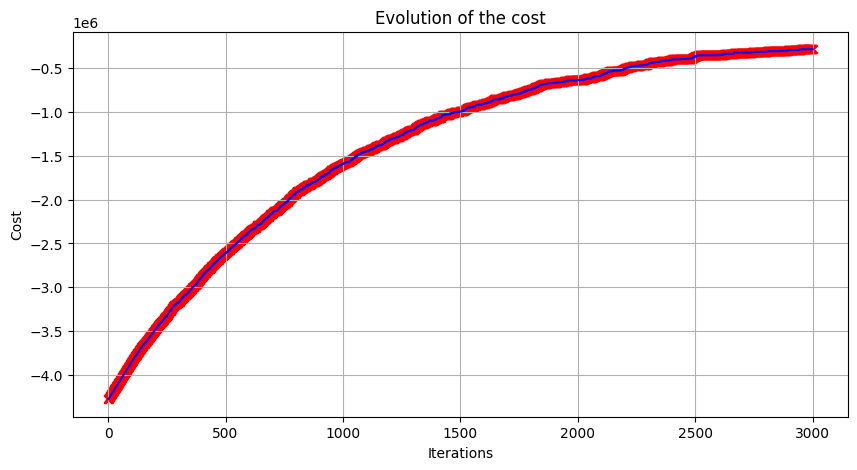

In [47]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]]:
    current_solution = initial_solution.copy()
    current_fitness = fitness(current_solution)
    history = [current_fitness[1]]

    step = 0
    while step < iterations:
        new_solution = tweak(current_solution)
        new_fitness = fitness(new_solution)
        history.append(current_fitness[1])

        if new_fitness[1] > current_fitness[1]:
            current_solution = new_solution
            current_fitness = new_fitness

        step += 1

    return current_solution, history

initial_solution = np.ones(NUM_SETS, dtype=bool)

solution, history = set_cover(initial_solution)

solution_fitness = fitness(solution)
if solution_fitness[0]:
    print(f"The solution is valid with a cost of {-solution_fitness[1]}")
else:
    print(f"The solution is not valid with a cost of {-solution_fitness[1]}")

plt.figure(figsize=(10, 5))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="blue",
)
plt.scatter(range(len(history)), history, color="red", marker="x")
plt.title("Evolution of the cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


We can clearly see that the algorihtm is pretty slow.

## A more powerful tweak

The solution is valid, the final cost is 206984.59703830426


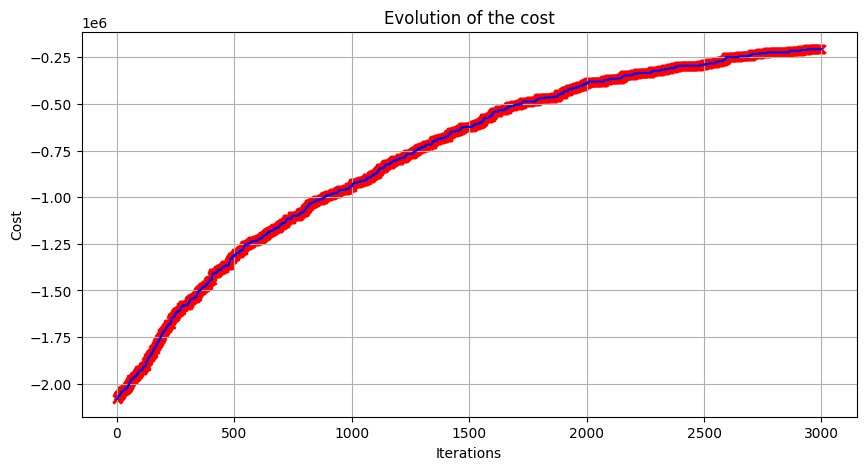

In [50]:
def tweak(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

initial_solution = np.random.random(NUM_SETS) < .5

solution, history = set_cover(initial_solution)

solution_fitness = fitness(solution)
print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')


plt.figure(figsize=(10, 5))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="blue",
)
plt.scatter(range(len(history)), history, color="red", marker="x")
plt.title("Evolution of the cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

It's a bit better than before but it can be improved.

## Adding the notion of strength

In order to be more efficient, we will try to combine larger and smaller steps. In the beginning, the larger steps will allow for a better exploration and the smaller steps towards the end will improve the exploitation.

The solution is valid, the final cost is 148779.5322629609


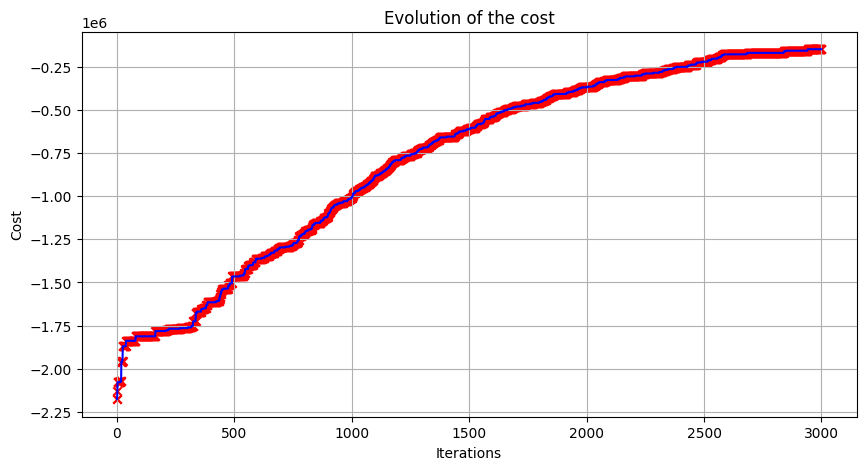

In [35]:
def tweak(current_solution: np.ndarray, adjustment_strength: float) -> np.ndarray:
    random_mask = np.random.random(NUM_SETS) < adjustment_strength
    if not np.any(random_mask):
        random_mask[np.random.randint(NUM_SETS)] = True 
    updated_solution = np.logical_xor(current_solution, random_mask)
    return updated_solution

def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]]:
    solution = initial_solution.copy()
    fitness_solution = fitness(solution)
    history = [fitness_solution[1]]
    adjustment_strength = 0.3

    for _ in range(iterations):
        adjustment_strength *= 0.994
        candidate_solution = tweak(solution, adjustment_strength)
        candidate_fitness = fitness(candidate_solution)
        history.append(fitness_solution[1])

        if candidate_fitness > fitness_solution:
            solution = candidate_solution
            fitness_solution = candidate_fitness

    return solution, history

solution, history = set_cover(initial_solution)

solution_fitness = fitness(solution)
validation = "" if solution_fitness[0] else " not"
print(f'The solution is{validation} valid, the final cost is {-solution_fitness[1]}')

plt.figure(figsize=(10, 5))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="blue",
)

plt.scatter(range(len(history)), history, color="red", marker="x")
plt.title("Evolution of the cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()


We managed to improve the exploration because we have a fast start as well as the exploitation because we got slower towards the end.

## Adding the notion of success

We are going to try the 1/5 success rule. If we have more than one success over five iterations we need to improve the strength but if we don't have it we need to decrease the strength.

The solution is valid, the final cost is 140709.12228823296


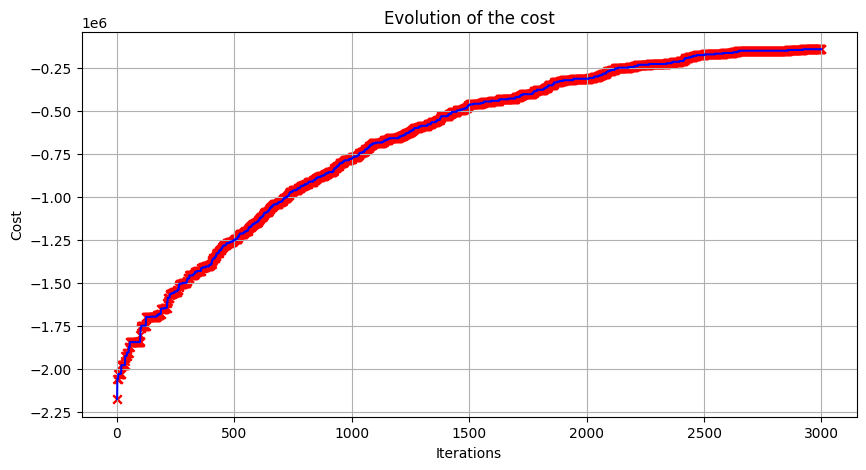

In [36]:
def set_cover(initial_solution: np.ndarray) -> tuple[np.ndarray, list[int]] :
    solution = initial_solution.copy()
    fitness_solution = fitness(solution)
    history = [fitness_solution[1]]
    strength = 0.3
    succes = 0
    c = 0.98
    for i in range(iterations):
        if i%5:
            if succes > 1:
                strength/c
            elif succes < 1:
                strength*=c
            succes = 0
        test_solution = tweak(solution, strength)
        fitness_test_solution = fitness(test_solution)
        history.append(fitness_solution[1])
        if fitness_test_solution > fitness_solution:
            solution = test_solution
            fitness_solution = fitness_test_solution
            succes += 1
    return solution, history

solution, history = set_cover(initial_solution)

solution_fitness = fitness(solution)
print(f'The solution is{"" if solution_fitness[0] else " not"} valid, the final cost is {-solution_fitness[1]}')

plt.figure(figsize=(10, 5))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="blue",
)

plt.scatter(range(len(history)), history, color="red", marker="x")
plt.title("Evolution of the cost")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

This is the best solution so far but there is always place for improvement.
